In [1]:
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax, argmin
from numpy import tensordot
from numpy.linalg import norm
import seaborn as sns
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_error
import gc
from sklearn.metrics import roc_curve,auc

C:\Users\Katherine\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Katherine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Katherine\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Katherine\Anaconda3\lib\site-packages\tensorflow\p

In [2]:
import glob
import os
folder_name = 'luce_stations_10'
file_type = 'txt'
seperator =' '

dataframe = pd.concat([pd.read_csv(f, sep=seperator, header=None) for f in glob.glob(folder_name + "/*."+file_type)],ignore_index=True)
dataframe.columns=['stationID','year','month','day','hour','min','sec','epoch','seq#','AmbientTemp','SurfaceTemp','Radiaiton','RH','Moisture','watermark','rain','windSpeed','WindDirection']

In [ ]:
df.describe()

In [3]:
df=dataframe.dropna(axis=1, thresh=243500).iloc[:,9:]

df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,AmbientTemp,SurfaceTemp,Radiaiton,RH,windSpeed,WindDirection
0,1.92,0.787,76.036,71.244,3.252,51.728
1,1.94,0.975,73.909,71.375,2.413,15.305
2,1.94,0.725,77.631,71.401,2.112,9.784
3,1.90,0.662,74.441,71.418,2.816,354.059
4,1.94,0.787,73.377,71.477,1.944,88.830


In [4]:
del dataframe
gc.collect()

0

In [78]:
from random import randint
start=randint(0, len(df)-6000)
print(start)
dataset = df.iloc[start:start+6000,]

199780


# normalize and add 5% noise

In [79]:
# normailize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(dataset.iloc[:3600,].values)
test_scaled = scaler.transform(dataset.iloc[3600:,].values)

In [80]:
# add 5% noises as anomalies into train and test data in order to evaluate the method
import math
    
qty=math.floor(len(train_scaled)*0.05)
train_anomalies=np.random.choice(train_scaled.shape[0],size = qty,replace=False)
print(train_anomalies)
temp_data=train_scaled[train_anomalies,:]+np.random.normal(0,1,size=train_scaled.shape[1])
i=0
for row in train_anomalies:
    train_scaled[row,:]=temp_data[i,:]
    i+=1

[ 948 3196 3523 2690 1371  912 3185 2829 1543 1376 3166 2223 1784 1480
 2243 1667  930 1968 2047 3343  765 2401 3309 2309  175 1661  802 2510
  677 1608 2314 1434  485 2730 3498  241 2565 1528 3154 1106 2123 1360
 2749 1172 2445   89  752 3289 3544 1447   99 2593 1933 3149 3454 3360
 1127 1092  627  664  846  199 3330 2324 2032  686 2602  226 3407  252
  825  509 1265 3243  848 3494 1886  268 3102 3127 2078  699 2865 2523
 2942 3575 3378 2391  632 1956 2266  681  355 1833  618 2499 1153 1011
 2177 3285 1285   58 2548 3135 3204 2632  758  940 2125 1805  954 2334
 2091 2393 3141 2097 3328  541 1398  741  539 1178  909  719  259   46
 2961 3144 1556 2624  549 1168 1313 1319  552 1631  337 2012 2076 3409
 2345 2691 3156  103 1050 2677  443  145 2301    6  823  420 1840 1427
 2803 1382 3486 3421  161 1997 3532 1567 1479 2421 1864 1561 1555 1869
 2784 2734  992  945  164 2987 1222 3061 2763  838 3017 1378]


In [81]:
qty=math.floor(len(test_scaled)*0.05)
test_anomalies=np.random.choice(test_scaled.shape[0],size = qty,replace=False)
print(test_anomalies)
temp_data=test_scaled[test_anomalies,:]+np.random.normal(0,1,size=test_scaled.shape[1])
i=0
for row in test_anomalies:
    test_scaled[row,:]=temp_data[i,:]
    i+=1

[1468 1584 1559 1853 1980 2305 2053 1409  474 2365 1836 1573  594  441
  249 1675 2147 1883 1336  577 1552  556  641 1311 1510 1355 1286 1206
 1459  830 1341  143   33  381 1162 1002  240  259 1808 1012 1120 1805
  629 1761  161 1995 1834 1125  874  675 1682 1016  121  661   30 1361
 1879  100 2024  471 1179  682  339  361 1732  317 1297 1316  123 1262
 1005 2342  413 1869 2256 1783 1181  119  753  809 1506   70   75   91
  955  770 2069  645  420 1564  569 1270  158  705 1013   18  463 1454
 1010  220 1060  252 1493  865 1574  159  647 1037  292  833   40  617
 1119  648 1030  637  137 2108 2172 1211]


In [10]:
# multivariate output data prep

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# fit Vanilla model on dataset
def fit_model(trainX, trainy,n_features):
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse',metrics=['mae'])
    # fit model
    model.fit(trainX, trainy, epochs=500, verbose=0)
    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX, testy):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    a_testy=array(testy)
    # weighted sum across ensemble members
    #summed = tensordot(abs(yhats-a_testy), weights, axes=((0),(0)))
    # argmax across classes
    #result = argmax(summed, axis=1)
    result = tensordot(yhats, weights, axes=((0),(0)))
    return result

# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, weights, testX, testy)
    # calculate MAE
    return mean_absolute_error(testy, yhat), yhat

In [82]:
n_steps = 5
# convert into input/output
X_train, y_train = split_sequences(train_scaled, n_steps)
print(X_train.shape, y_train.shape)
print(y_train[1])

(3595, 5, 6) (3595, 6)
[-2.12169634  0.95105667  2.3946743  -0.36657561  0.28914424  1.3298224 ]


In [83]:
n_steps = 5
# convert into input/output
X_test, y_test = split_sequences(test_scaled, n_steps)
print(X_test.shape, y_test.shape)
print(y_test[1])

(2395, 5, 6) (2395, 6)
[6.55737705e-02 3.25217391e-02 9.00950509e-03 6.88628624e-01
 4.15865049e-01 5.43175448e-04]


In [84]:
n_features = X_train.shape[2]
n_members = 5
members = [fit_model(X_train, y_train,n_features) for _ in range(n_members)]
# evaluate each single model on the test set

for i in range(n_members):
    _, test_acc = members[i].evaluate(X_test, y_test, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score, prediction = evaluate_ensemble(members, weights, X_test, y_test)
print('Equal Weights Score: %.3f' % score)

Model 1: 0.540
Model 2: 0.787
Model 3: 0.649
Model 4: 0.535
Model 5: 0.371
Equal Weights Score: 0.384


In [14]:
# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return evaluate_ensemble(members, normalized, testX, testy)[0]

In [85]:
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, X_test, y_test)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=8000, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score, prediction = evaluate_ensemble(members, weights, X_test, y_test)
print('Optimized Weights Score: %.3f' % score)

Optimized Weights: [0.18411289 0.02035553 0.08259149 0.14054907 0.57239102]
Optimized Weights Score: 0.327


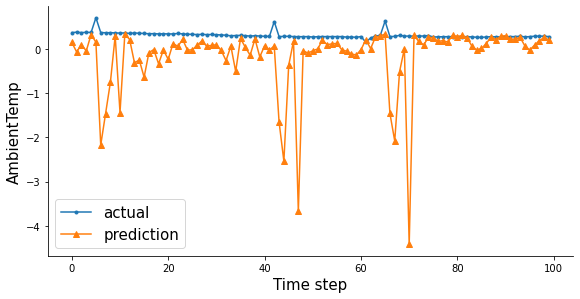

In [86]:
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[-100:,0], marker='.', label="actual")
plt.plot(aa, prediction[-100:,0], marker='^', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('AmbientTemp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# Calculate Euclidean distance

In [87]:
temp = [] #temporary list
for j in range(len(y_test)):
    dis = sum([pow(y_test[j][i] - prediction[j][i], 2) for i in range(n_features)])
    temp.append(round(pow(dis, 0.5),4))
print(len(temp))

2395


In [88]:
array_dis=np.array(temp)
thold= np.percentile(array_dis,95)
outcome=[]
for a in array_dis:
    if a <= thold:
        outcome.append(1.0) #1 is normal
    else:
        outcome.append(0.0) #0 is abnormals
#outcome 

In [89]:
b = np.ones((len(test_scaled),1))
rows=test_anomalies
b[rows] = 0
test_scaled_anomolies=np.hstack((test_scaled,b))

In [90]:
scaled_test_df = pd.DataFrame({'act_AmbientTemp': y_test[:, 0], 'act_SurfaceTemp': y_test[:, 1],'act_Radiaiton': y_test[:, 2], 
                               'act_RH': y_test[:, 3],'act_windSpeed': y_test[:, 4], 'act_WindDirection': y_test[:, 5],
                               'prd_AmbientTemp': prediction[:, 0], 'prd_SurfaceTemp': prediction[:, 1],'prd_Radiaiton': prediction[:, 2],
                               'prd_RH': prediction[:, 3],'prd_windSpeed': prediction[:, 4], 'prd_WindDirection': prediction[:, 5],
                               'Euclidean distance': array_dis,'act_class':test_scaled_anomolies[5:,-1], 'prd_class':outcome})
#scaled_test_df
scaled_test_df.to_excel("scaled_test_df-ensemble(5)-(r5).xlsx")

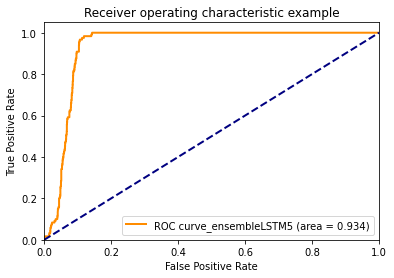

In [91]:
fpr, tpr, thresholds = roc_curve(scaled_test_df['act_class'], scaled_test_df['Euclidean distance'],pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve_ensembleLSTM5 (area = %0.3f)' % roc_auc)
#plt.plot(fpr1, tpr1, color='green',lw=lw, label='ROC curve_LSTM7 (area = %0.3f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_back=scaler.inverse_transform(y_test)